# EE-411 Fundamentals of inference and learning, EPFL 
## Exercise Session 6: Ridge Regression and Lasso on real datasets

In this sixth set of exercises, we will see how to implement the methods introduced in the last exercise session and discussed in the last lecture to work with some real datasets. We will see which are the differences between these regularized least-square methods and the standard OLS solution.

**What you will learn today:**  In this sixth notebook, we shall see how to use scikit-learn to implement Ridge and Lasso. We also introduce `pipelines`, an important tool which is frequently used in Machine Learning. Furthermore, we will linger on the important concept of sparsity.

In [1]:
#We import the usual packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# A) Ozone
---
Let us look at a particular real-life data problem. In the following example we take the prediction of ozone concentration as a factor of other weather-based features. As with all data problems, it behooves us to take a look at all of the information that we have about the dataset.

#### Dataset loading

In [2]:
data =   pd.read_csv('https://web.stanford.edu/~hastie/ElemStatLearn/datasets/LAozone.data')
data.head()

,ozone,vh,wind,humidity,temp,ibh,dpg,ibt,vis,doy
0,3,5710,4,28,40,2693,-25,87,250,3
1,5,5700,3,37,45,590,-24,128,100,4
2,5,5760,3,51,54,1450,25,139,60,5
3,6,5720,4,69,35,1568,15,121,60,6
4,4,5790,6,19,45,2631,-33,123,100,7


Alright, we're ready to get started ! Now, before we touch anything, we need to follow best practices. When faced with a new dataset, we need to split it into three parts: **Training**(and within that, **Validation**), and **Testing** sets. 

The best practice here is to take the test data and lock it away somewhere. It is always tempting to tune your algorithms to give the best test performance. However, even if the regression isn't explicitly *trained* on the test data, as practitioners, we could be continually making changes in an effort to get our numbers up.

Instead, we should deep-freeze the test data, and then tune as much as we can via **cross-validation (CV)** on our training data.

#### Train/Test splitting

In [3]:
from sklearn.model_selection import train_test_split

#--- Convert from DataFrame to NDArray ---#
# We also ensure that we load in all data as floating point values
# so that we don't miss anything to truncations.
y = data['ozone'].to_numpy().astype(float)
X = data[data.columns[1:]].to_numpy()

#--- Split Dataset ---#
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size = 0.25, random_state=1)

print("Training Samples: ", len(yTrain))
print("Testing  Samples: ", len(yTest))

Training Samples:  247
Testing  Samples:  83


Now, before we start attempting to fit models, lets take a bit of care and apply some pre-processing to our dataset. The de-facto pre-processing is *centering and normalization*. Specifically, many flavors of estimators (OLS, RR, etc.) can be thrown off by large differences in scale and variations between the features. We can easily account for this in our estimators by simply normalizing the feature columns and removing averages. Scikit-Learn has some features to do this automatically!

#### Preprocessing

In [4]:
from sklearn import preprocessing

#--- Scaling ---#
scaler = preprocessing.StandardScaler().fit(XTrain)
XTest_scaled = scaler.transform(XTest)
XTrain_scaled = scaler.transform(XTrain)

#--- Center observations (simplify the OLS)---#
yTrain_mean = np.mean(yTrain)
yTrain_centered = yTrain - yTrain_mean

Now it is time for us to choose our estimator. What should we choose? 

## Attempt 1: ordinary least squares (OLS)
---



If you remember last exercise session, the equation to solve is of the type

$$
(X^T X) \hat {\mathbf w} = X^T {\mathbf y}
$$

The function `linalg.solve(a,b)` can be used to solve a system of linear scalar equations $ax=b$, thus we can use it to compute the prediction of the model both on the train and on the test datasets

In [5]:
#--- Compute the OLS Estimate ---#
regOLS = np.linalg.solve(np.dot(XTrain_scaled.T,XTrain_scaled), np.dot(XTrain_scaled.T,yTrain_centered))

yp = np.dot(XTrain_scaled, regOLS)
ypTest = np.dot(XTest_scaled, regOLS)

Let's see now how well the prediction performance looks and which are the learned parameters corresponding to the OLS solution

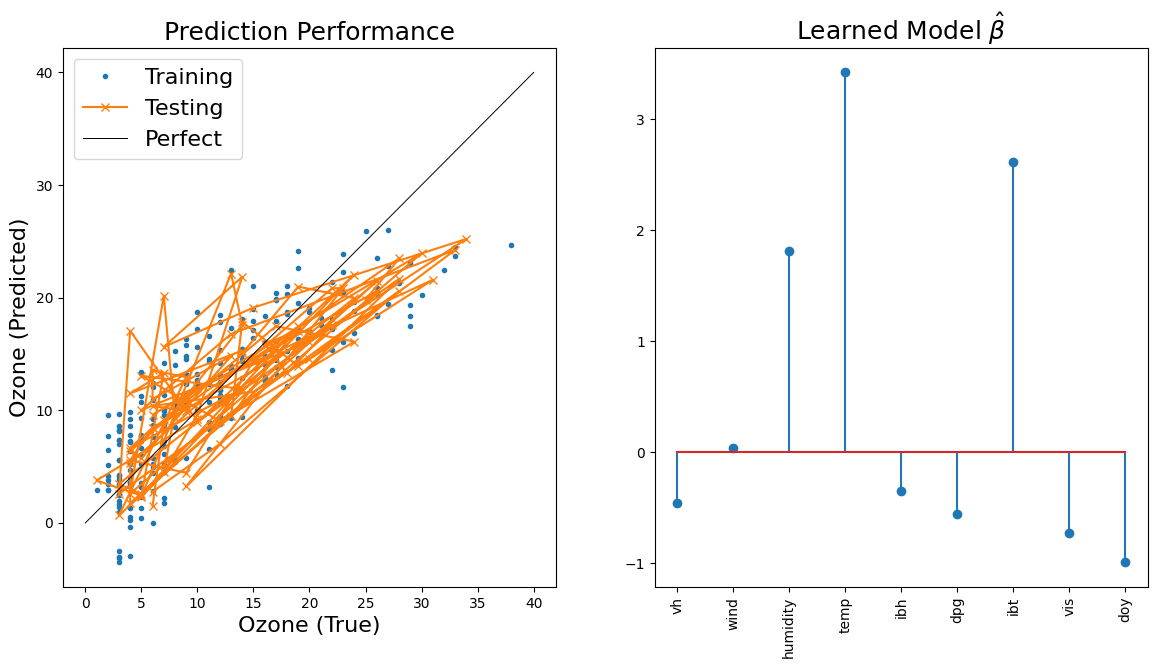

In [6]:
#--- Visualize ---#
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(yTrain, yp + yTrain_mean,'.', label='Training') #remember to add again the mean when you plot
plt.plot(yTest, ypTest + yTrain_mean, label='Testing', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
# plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)
# Plot the learned model
plt.subplot(122)
plt.stem(regOLS)
plt.title('Learned Model $\\hat{\\beta}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical');

Finally, to see how well the model is performing, we can compute the Residual Sum of Squares (RSS) for both the train and the test set

In [7]:
#--- Print RSS ---#
rss_train = np.mean(np.power(yTrain_centered - yp,2))
rss_test = np.mean(np.power(yTest - yTrain_mean - ypTest,2))
print("Normalized RSS (Train): %0.2f" % rss_train)
print("Normalized RSS  (Test): %0.2f" % rss_test)

Normalized RSS (Train): 18.28
Normalized RSS  (Test): 22.53


The same thing could have been done using the packages present in **Scikit-Learn**

In [8]:
from sklearn import linear_model

#--- Define OLS Estimator ---#
regL = linear_model.LinearRegression()
#--- Fit the parameters ---#
regL.fit(XTrain_scaled,yTrain_centered)
#--- Use the learned coefficients to predict the y ---#
yp_L = regL.predict(XTrain_scaled)
ypTest_L = regL.predict(XTest_scaled)

**Note:** the standard value `fit_intercept=True` in `LinearRegression`, but also in `Ridge` and in `Lasso`, allows us not to think about the intercept, since it is automatically considered by the method.

#### 1) Compare these estimates to the preivious ones, computed without considering the intercept. Why they are so similar?
 - Is the intercept fitted by `LinearRegression` big? 
 - What's the difference in the MSE of the two prediction?
 - (bonus) Make a plot!

In [9]:
regL.intercept_ #is very small

np.float64(-2.272470277293798e-15)

In [10]:
np.sum(yp-yp_L)

np.float64(5.730138585846589e-13)

In [11]:
np.sum(ypTest-ypTest_L)

np.float64(7.714662242364057e-14)

#### 2) Prove that fitting the intercept (as `LinearRegression`) is equivalent to what we did (subtracting the mean). (Hint: remember that the inpunts are scaled!)

When we fit the intercept, out model is $y =  {\mathbf w} \cdot x +{c}$. The loss function writes as
$$\mathcal L({\mathbf w}, {c}) = \frac{1}{2} \sum_{i=1}^n (y_i-\mathbf w \cdot x_i-c)^2.$$

The best estimator is the one that minimize the loss. Since the problem is convex, we can write it as
$$\left.\frac{d\mathcal L}{d w}\right|_{\mathbf w = \hat{\mathbf w}} = 0$$
$$\left.\frac{d\mathcal L}{d c}\right|_{c = \hat{c}} = 0$$
This is a system of equations, but we will show that we can look at one equations at the time. Let's focus on the latter. After simple calculations we see that
$$\hat{c} = \frac1n \sum_{i=1}^n(y_i-\hat{\mathbf w}\cdot x_i)$$
Working on the second term and remembering that inputa are scaled ($\frac1n\sum_{a=1}^d x_i^a = 0\quad \forall i$), we finally have 
$$\hat{c} = \frac1n \sum_{i=1}^n y_i.$$

In the end, the actually best predictor for the intercept is exactly the mean, so centering the outputs is completellly equivalent to fitting the intercept.

## Attempt 2: Ridge Regression
---

For RR, that we implemented by hand in the last notebook, we can use directly Scikit-learn. First of all, we import as always the model, choosing for now the regularization constant $\alpha = 0.01$

In [12]:
#--- Define Regression Estimator ---#
regRR = linear_model.Ridge(alpha=0.01)

Now, we need to perform some kind of cross-validation (CV) to find the best set of parameters for our model. We will do this by constructing a **Pipeline**. A pipeline is a useful way of handling pre-processing on separate data partitions when performing CV. Let's take a look at that.

In the next cell we use the pipeline to do two things:

* We standardize features by removing the mean and scaling to unit variance (it is done by `preprocessing.StandardScaler()`)

* We implement the fitting strategy; namely Ridge Regression

#### Pipeline

In [13]:
from sklearn.pipeline import make_pipeline 

#--- Make a Pre-processing + Fitting Pipeline ---#
pipe_regRR = make_pipeline(preprocessing.StandardScaler(), regRR)

After that, we have  to define a Scoring Metric. In this case, to compare the fits we look at the prediction error via the RSS.

In [14]:
#--- Define a Scoring Metric (Residual Sum of Squares) ---#
def neg_rss(reg, X, y):
    yp = reg.predict(X)
    return -np.mean(np.power(y - yp,2))

 We can then create an iterator which performs a set of **randomized splits on the dataset into "train" and "validation"**. 
 
Obviously, we have a trade-off between the test set size and the number of splits we should perform.

In [15]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

#--- Define CV Splitting ---#
cv = ShuffleSplit(n_splits=30, test_size=0.05, random_state=1)

#--- Define the Parameters to Search ---#
param_grid = [
    {'ridge__alpha': np.logspace(-5,3,100)} # we do CV for values of alpha between 0.0001 and 1000
]

Finally, we use `GradSearchCV` to find which is the best value of the parameter $\alpha$

In [16]:
#--- Define CV ---#
cv_regRR = GridSearchCV(pipe_regRR, param_grid, scoring=neg_rss, cv=cv,return_train_score=True) #Note that we need to use the RSS with a minus sign!

In [17]:
#--- Run CV ---#
cv_regRR.fit(XTrain,yTrain)

GridSearchCV(cv=ShuffleSplit(n_splits=30, random_state=1, test_size=0.05, train_size=None),
             estimator=Pipeline(steps=[('standardscaler', StandardScaler()),
                                       ('ridge', Ridge(alpha=0.01))]),
             param_grid=[{'ridge__alpha': array([1.00000000e-05, 1.20450354e-05, 1.45082878e-05, 1.74752840e-05,
       2.10490414e-05, 2.53536449e-05, 3.05385551e-05, 3.67837977e-05,
       4.43062146e-05,...
       2.91505306e+01, 3.51119173e+01, 4.22924287e+01, 5.09413801e+01,
       6.13590727e+01, 7.39072203e+01, 8.90215085e+01, 1.07226722e+02,
       1.29154967e+02, 1.55567614e+02, 1.87381742e+02, 2.25701972e+02,
       2.71858824e+02, 3.27454916e+02, 3.94420606e+02, 4.75081016e+02,
       5.72236766e+02, 6.89261210e+02, 8.30217568e+02, 1.00000000e+03])}],
             return_train_score=True,
             scoring=<function neg_rss at 0x7f471c2b8220>)

Great! Now lets take a look at the performance of our estimator. Here, for example of Ridge regression, we chart over the $\alpha$ parameter that we perform CV against.

First of all, we save in `cvOptAlpha` the optimal regularization parameter $\alpha$ found by the grid search, and in `cvOptParams` the corresponding parameters

In [18]:
#--- Record CV Optimizing Hyper-Params ---#
cvOptAlpha = cv_regRR.cv_results_['param_ridge__alpha'][cv_regRR.best_index_]
cvOptParams = cv_regRR.best_estimator_['ridge'].coef_

In [19]:
cvOptAlpha

np.float64(11.49756995397738)

Then, we can plot the performance versus the regularization parameter $\alpha$

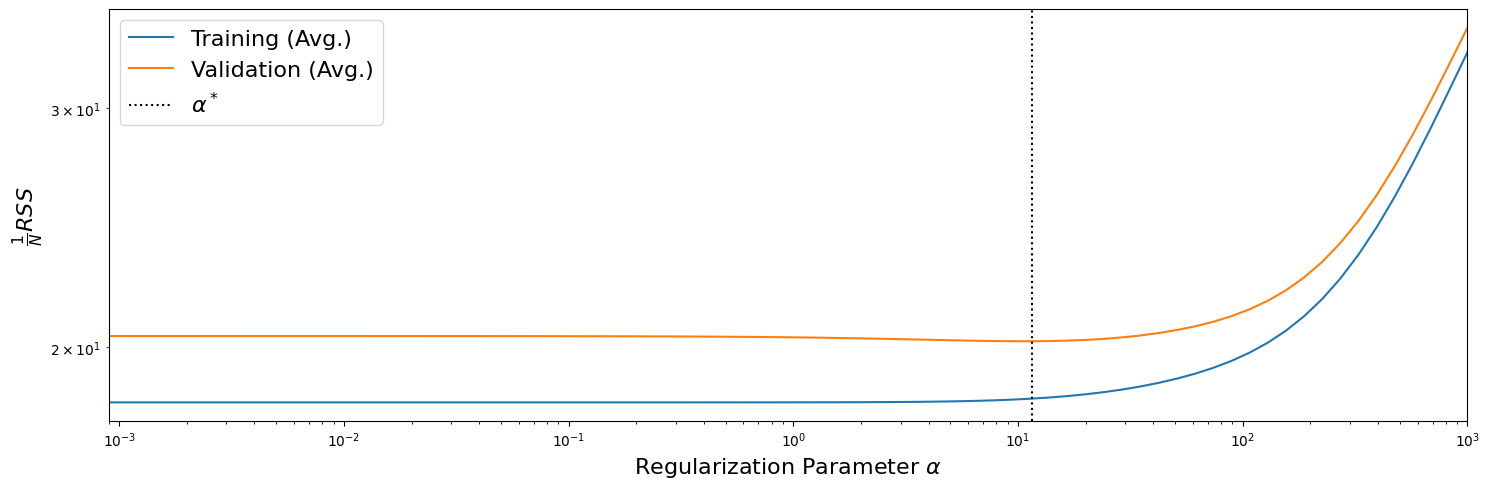

In [20]:
#--- Visualize ---#
testedAlpha = cv_regRR.cv_results_['param_ridge__alpha']
trainScores = -cv_regRR.cv_results_['mean_train_score']   # Reverse Sign
testScores = -cv_regRR.cv_results_['mean_test_score']    # Reverse Sign

plt.figure(figsize=(15,5))
plt.plot(testedAlpha, trainScores, '-', label='Training (Avg.)')
plt.plot(testedAlpha, testScores, '-', label='Validation (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.axvline(cvOptAlpha, label='$\\alpha^*$', color='k', linestyle=':')
plt.xscale('log')
plt.xlim([0.9*1e-3, 1e3])
plt.yscale('log')
plt.tight_layout()
plt.legend(loc=2, fontsize=16)

Now, lets take a look at how well we are able to make our predictions on the training set using this CV optimal value of $\alpha$.

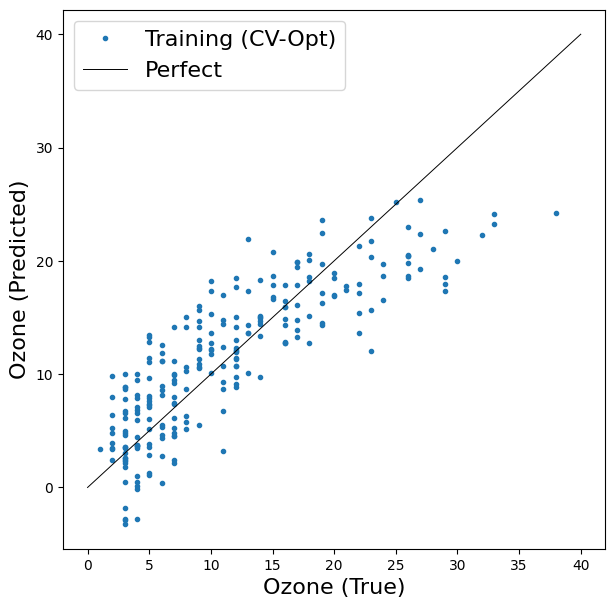

In [21]:
#--- Get Training Predicitions ---#
pipe_regRR.set_params(ridge__alpha=cvOptAlpha) # !!! how to pass parameters to pipelines
pipe_regRR.fit(XTrain, yTrain)
yp = pipe_regRR.predict(XTrain)

#--- Visualize ---#
plt.figure(figsize=(7,7))
plt.plot(yTrain, yp, '.', label='Training (CV-Opt)')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
# plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16);

And now, finally, we are ready to take our test data out of deep-freeze. How did we do?

#### 3) Plot, as we previously did for OLS, the prediction performance and the learned parameters. After having done that, compute the RSS and compare it to the OLS one

/tmp/ipykernel_56038/2673880706.py:7: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".r" (-> marker='.'). The keyword argument will take precedence.
  plt.plot(yTest, ypTest, '.r', label='Testing (CV-Opt)', marker='x')


Normalized RSS (Train): 18.38
Normalized RSS  (Test): 22.66


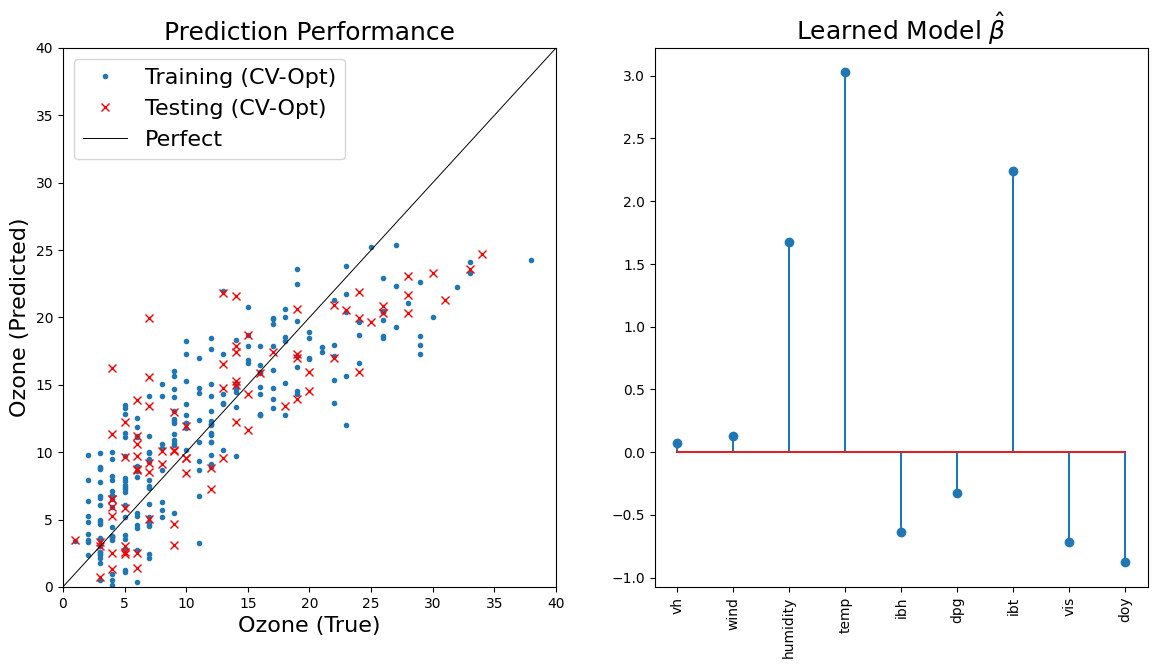

In [22]:
ypTest = pipe_regRR.predict(XTest)

#--- Visualize ---#
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(yTrain, yp, '.', label='Training (CV-Opt)')
plt.plot(yTest, ypTest, '.r', label='Testing (CV-Opt)', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)
# Plot the learned model
plt.subplot(122)
plt.stem(cvOptParams)
plt.title('Learned Model $\\hat{\\beta}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical')

#--- Print RSS ---#
print("Normalized RSS (Train): %0.2f" % -neg_rss(pipe_regRR, XTrain, yTrain))
print("Normalized RSS  (Test): %0.2f" % -neg_rss(pipe_regRR, XTest, yTest))

## Attempt 3: Lasso
---


### 4) Your turn: using the `linear_model.Lasso` estimator present in Scikit-Learn,  repeat the steps done for Ridge Regression:
* Create the pipeline for preprocessing + regressor
* Do the Grid Search to find the optimal regularization parameter
* Visualize how the performance varies when we change the regularization parameter 
* Plot the prediction performance and the learned parameters. What do you observe?
* Compute the RSS and compare it to the RR and the OLS one.

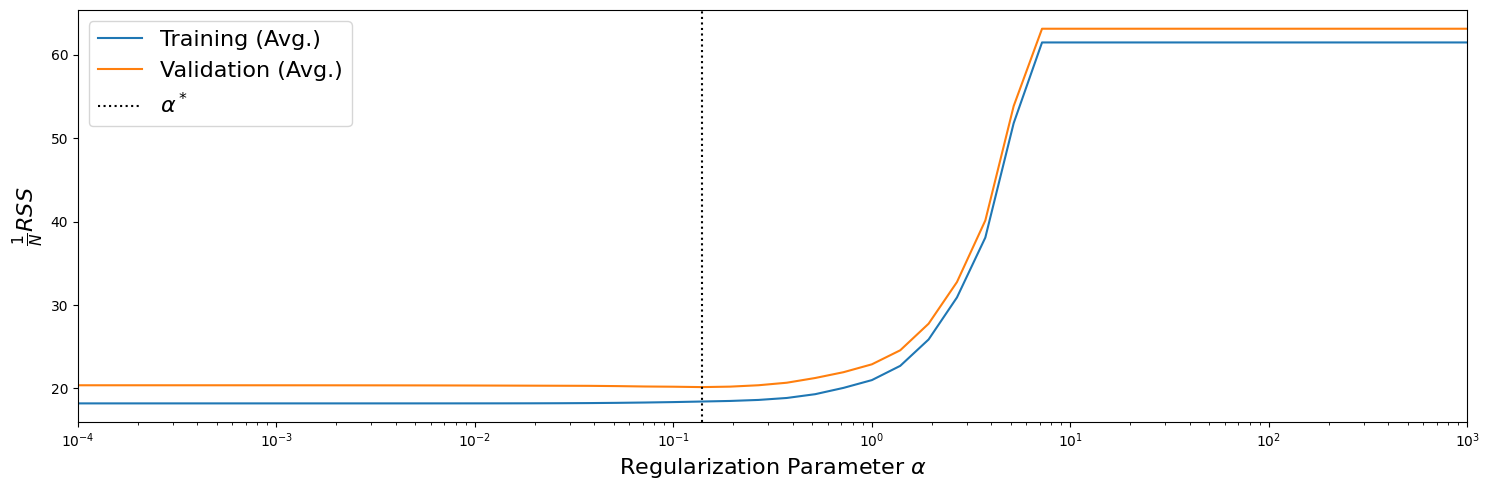

In [23]:
#--- Construct Estimator ---#
regLasso = linear_model.Lasso(alpha=1.0)

#--- Make a Pre-processing + Fitting Pipeline ---#
pipe_regLasso = make_pipeline(preprocessing.StandardScaler(), regLasso)

#--- Define the Parameters to Search ---#
# We need to specify the estimator name since we are performing a CV on
# a Pipeline. (e.g. the formatting of `<estimator>__<param>`).
param_grid = [
    {'lasso__alpha': np.logspace(-4,3,50)}
]

#--- Run the CV ---#
cv_regLasso = GridSearchCV(pipe_regLasso, param_grid, scoring=neg_rss, cv=cv, return_train_score=True)
cv_regLasso.fit(XTrain,yTrain)

#--- Record CV Optimizing Hyper-Params ---#
cvOptAlphaLasso = cv_regLasso.cv_results_['param_lasso__alpha'][cv_regLasso.best_index_]
cvOptParamsLasso = cv_regLasso.best_estimator_['lasso'].coef_

#--- Visualize ---#
testedAlpha = cv_regLasso.cv_results_['param_lasso__alpha']
trainScores = -cv_regLasso.cv_results_['mean_train_score']   # Reverse Sign
testScores = -cv_regLasso.cv_results_['mean_test_score']     # Reverse Sign

plt.figure(figsize=(15,5))
plt.plot(testedAlpha, trainScores, '-', label='Training (Avg.)')
plt.plot(testedAlpha, testScores, '-', label='Validation (Avg.)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.axvline(cvOptAlphaLasso, label='$\\alpha^*$', color='k', linestyle=':')
plt.xscale('log')
plt.xlim([1e-4, 1e3])
plt.tight_layout()
plt.legend(loc=2, fontsize=16)

/tmp/ipykernel_56038/3954326259.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".r" (-> marker='.'). The keyword argument will take precedence.
  plt.plot(yTest, ypTest, '.r', label='Testing (CV-Opt)', marker='x')


Normalized RSS (Train): 18.49
Normalized RSS  (Test): 22.17


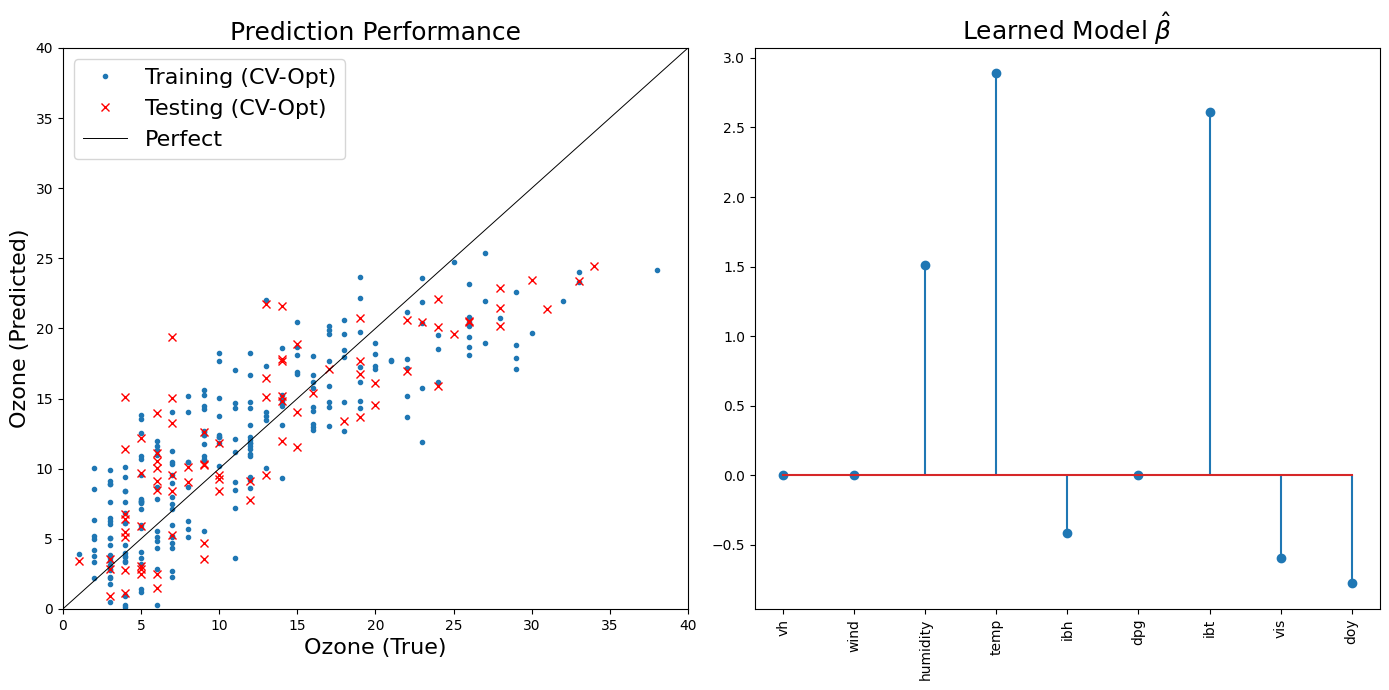

In [24]:
#--- Get Training Predicitions ---#
pipe_regLasso.set_params(lasso__alpha=cvOptAlphaLasso)
pipe_regLasso.fit(XTrain,yTrain)
yp = pipe_regLasso.predict(XTrain)
ypTest = pipe_regLasso.predict(XTest)

#--- Visualize ---#
# Plot prediction performance
plt.figure(figsize=(14,7))
plt.subplot(121)
plt.plot(yTrain, yp, '.', label='Training (CV-Opt)')
plt.plot(yTest, ypTest, '.r', label='Testing (CV-Opt)', marker='x')
plt.plot([0, 40], [0, 40], '-k', linewidth=0.7, label="Perfect")
plt.axis([0, 40, 0, 40])
plt.xlabel('Ozone (True)', fontsize=16)
plt.ylabel('Ozone (Predicted)', fontsize=16)
plt.legend(loc=2, fontsize=16)
plt.title('Prediction Performance', fontsize=18)
# Plot the learned model
plt.subplot(122)
plt.stem(cvOptParamsLasso)
plt.title('Learned Model $\\hat{\\beta}$', fontsize=18)
plt.xticks(range(9),data.keys()[1:10], rotation='vertical')

plt.tight_layout()
#--- Print RSS ---#
print("Normalized RSS (Train): %0.2f" % -neg_rss(pipe_regLasso, XTrain, yTrain))
print("Normalized RSS  (Test): %0.2f" % -neg_rss(pipe_regLasso, XTest, yTest))

# B) Diabetes

We will now perform some numerical experiments with the Diabetes Dataset trying to predict diabetes outcomes one year forward. This is a classical dataset in statistics, and more information can be found at <a href="https://archive.ics.uci.edu/ml/datasets/Diabetes">https://archive.ics.uci.edu/ml/datasets/Diabetes</a>. Here is what we have: 10 baseline variables: age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of $n = 442$ diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline.

Our first goal is to plot the weights for each value of $\lambda$ for Ridge Regression and LASSO. This is called a **regularization path**.

We first load the dataset

In [25]:
from sklearn import datasets

# Load Training Data set with 442 examples

number_examples=442
diabetes = datasets.load_diabetes()
print(diabetes.DESCR)
X = diabetes.data[:number_examples]
y = diabetes.target[:number_examples]

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [26]:
df = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
df.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


### 5) Using the pipelines `pipe_regRR` and `pipe_regLasso` constructed before for the Ozone problem:

* Divide the dataset such that you have 150 training samples and 50 test samples
* Do the Grid Search to find the optimal regularization parameters, for $\alpha$ in $[10^{-2},10^5]$
* Visualize how the performance varies when we change the regularization parameter, comparing Rindge and Lasso

### 6) Then aswer to these questions [EVALUATED]:
- What do the points $\alpha=0$  and  $\alpha = +\infty$  correspond to? Why for these values both the regularizations give the same result?

- What is the qualitative difference between the LASSO path and Ridge Path? (Plot it as well in linear scale)

In [27]:
XTrain, XTest, yTrain, yTest = train_test_split(X,y,test_size = 0.25, random_state=1)

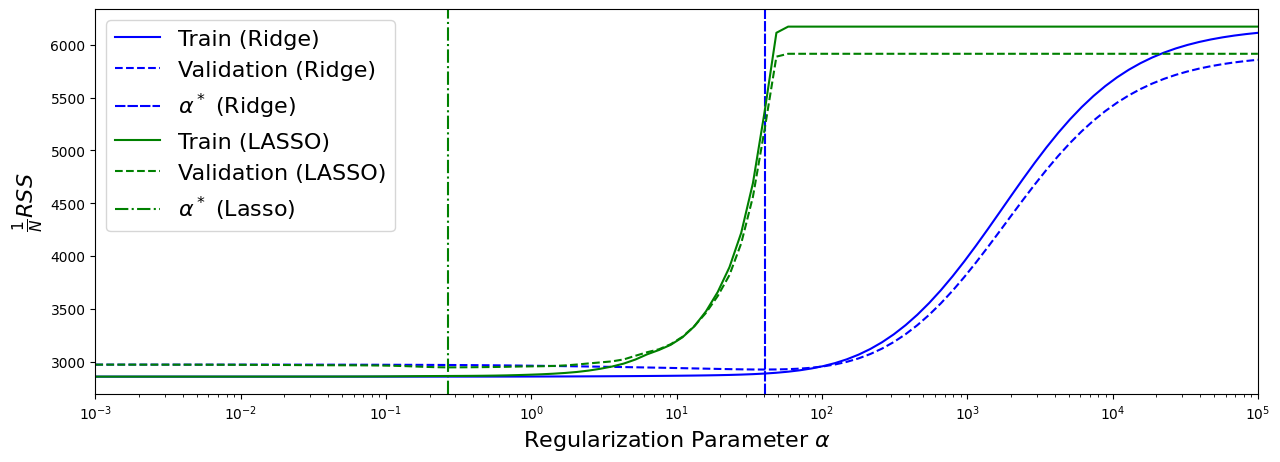

In [28]:
#--- We take the same pipeline, modyfing the rannge of alpha ---#
#--- Run the CV ---#

param_grid = [
    {'ridge__alpha': np.logspace(-3,5,100)}
]

cv_regRR = GridSearchCV(pipe_regRR, param_grid, scoring=neg_rss, cv=cv, return_train_score=True)
cv_regRR.fit(XTrain,yTrain)

param_grid = [
    {'lasso__alpha': np.logspace(-3,5,100)}
]

cv_regLasso = GridSearchCV(pipe_regLasso, param_grid, scoring=neg_rss, cv=cv, return_train_score=True)
cv_regLasso.fit(XTrain,yTrain)

#--- Record CV Optimizing Hyper-Params ---#
cvOptAlphaRR = cv_regRR.cv_results_['param_ridge__alpha'][cv_regRR.best_index_]
cvOptParamsRR = cv_regRR.cv_results_['params'][cv_regRR.best_index_]

cvOptAlphaLasso = cv_regLasso.cv_results_['param_lasso__alpha'][cv_regLasso.best_index_]
cvOptParamsLasso = cv_regLasso.cv_results_['params'][cv_regLasso.best_index_]

#--- Visualize ---#
testedAlpha_RR = cv_regRR.cv_results_['param_ridge__alpha']
trainScores_RR = -cv_regRR.cv_results_['mean_train_score']   # Reverse Sign
testScores_RR = -cv_regRR.cv_results_['mean_test_score']     # Reverse Sign

testedAlpha_Lasso = cv_regLasso.cv_results_['param_lasso__alpha']
trainScores_Lasso = -cv_regLasso.cv_results_['mean_train_score']   # Reverse Sign
testScores_Lasso = -cv_regLasso.cv_results_['mean_test_score']     # Reverse Sign

plt.figure(figsize=(15,5))
plt.plot(testedAlpha_RR, trainScores_RR, 'b', label='Train (Ridge)')
plt.plot(testedAlpha_RR, testScores_RR, '--b',label='Validation (Ridge)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.axvline(cvOptAlphaRR, label='$\\alpha^*$ (Ridge)', color='b', linestyle=(0, (5, 1)))

plt.plot(testedAlpha_Lasso , trainScores_Lasso ,'g',label='Train (LASSO)')
plt.plot(testedAlpha_Lasso , testScores_Lasso , '--g',label='Validation (LASSO)')
plt.xlabel('Regularization Parameter $\\alpha$', fontsize=16)
plt.ylabel('$\\frac{1}{N}RSS$', fontsize=16)
plt.axvline(cvOptAlphaLasso, label='$\\alpha^*$ (Lasso)', color='g', linestyle='-.')
plt.xscale('log')
plt.xlim([1e-3, 1e5])

#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k'
plt.legend(loc="best", fontsize=16)

We can also compare the in-sample and out-of-sample performance between two regressions by examining the $R^2$ coefficient of determination (for detailed definition see <a href="https://en.wikipedia.org/wiki/Coefficient_of_determination">here</a>). In terms of linear regression, $R^2$ tells us how well the regression function fits the data. The best attainable fit corresponds to $R^2=1$.


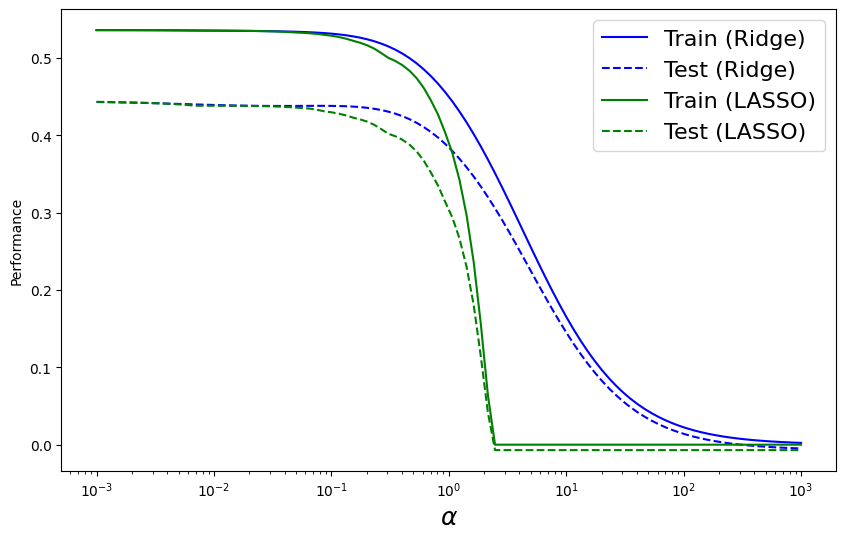

In [29]:
# This code is modified from plot_cv_diabetes.py in the sklearn documentation and plot_ridge_path.py

# Set up Lasso and Ridge Regression models
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()

# Chooose paths
alphas = np.logspace(-3, 3, 100)

# We partition the dataset into a training set with 150 
# as well as a test set with 50 examples. We record their errors respectively.

train_errors_ridge = list()
test_errors_ridge = list()

train_errors_lasso = list()
test_errors_lasso = list()

# Initialize coefficients for ridge regression and Lasso

coefs_ridge = []
coefs_lasso=[]
for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(XTrain, yTrain)
    coefs_ridge.append(ridge.coef_)
    
    # Use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(XTrain, yTrain))
    test_errors_ridge.append(ridge.score(XTest, yTest))
    
    lasso.set_params(alpha=a)
    lasso.fit(XTrain, yTrain)
    coefs_lasso.append(lasso.coef_)
    train_errors_lasso.append(lasso.score(XTrain, yTrain)) #the function score automatically computes the R squared
    test_errors_lasso.append(lasso.score(XTest, yTest))
    
###############################################################################
# Display results
plt.figure(figsize=(10,6))
# Plot our performance on both the training and test data
plt.semilogx(alphas, train_errors_ridge, 'b',label='Train (Ridge)')
plt.semilogx(alphas, test_errors_ridge, '--b',label='Test (Ridge)')
plt.semilogx(alphas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(alphas, test_errors_lasso, '--g',label='Test (LASSO)')
plt.legend(loc='upper right', fontsize=16)
#plt.ylim([-0.4, 1.0])
plt.xlabel(r'$\alpha$',fontsize=18)
plt.ylabel('Performance')
plt.show()



Finally, we can also see how the 10 features we learned scale as we change the regularization parameter

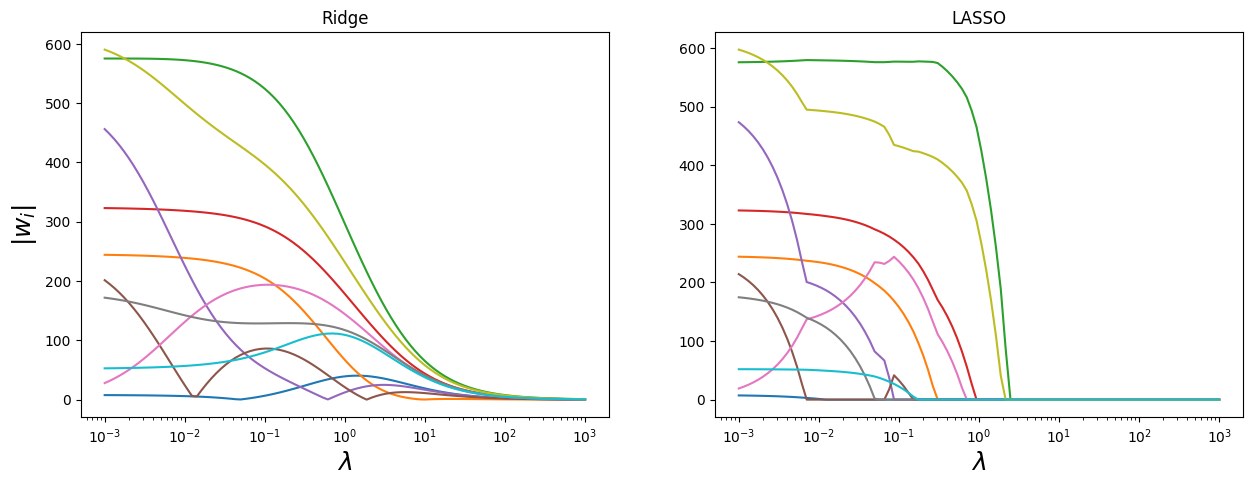

In [30]:
plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.semilogx(alphas, np.abs(coefs_ridge))
axes = plt.gca()
plt.xlabel(r'$\lambda$',fontsize=18)
plt.ylabel('$|w_i|$',fontsize=18)
plt.title('Ridge')



plt.subplot(1,2,2)
plt.semilogx(alphas, np.abs(coefs_lasso))
axes = plt.gca()
plt.xlabel(r'$\lambda$',fontsize=18)
plt.title('LASSO')
plt.show()

# Classification with Logistic regression and SVM 

**What you will learn today**: You will learn how to implement a classifier. First we will analyze a toy example in which we will use a logistic classifier coded from scratch. Once we understood the logic behind the algorithm we will use the black box Sklearn one for recognizing hand-written digits. You will also implement SVM classifier on a different dataset to get familiar with this important family of algorithm.

# 1) Logistic regression from scratch

Let us generate a synthetic dataset using a multivariate Gaussian distribution

In [31]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
num_observations = 500

x1 = np.random.multivariate_normal([0, 0], [[1, .5],[.5, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .8],[.8, 1]], num_observations)

dataset = np.vstack((x1, x2)).astype(np.float32)
labels = np.hstack((np.zeros(num_observations),np.ones(num_observations)))

dataset[:5]

array([[-1.7277927 , -1.3276355 ],
       [-1.9680586 ,  0.27283463],
       [-1.1287137 , -2.1059916 ],
       [-0.7471221 , -0.8984793 ],
       [-0.1159091 ,  0.2946894 ]], dtype=float32)

Let's plot our data

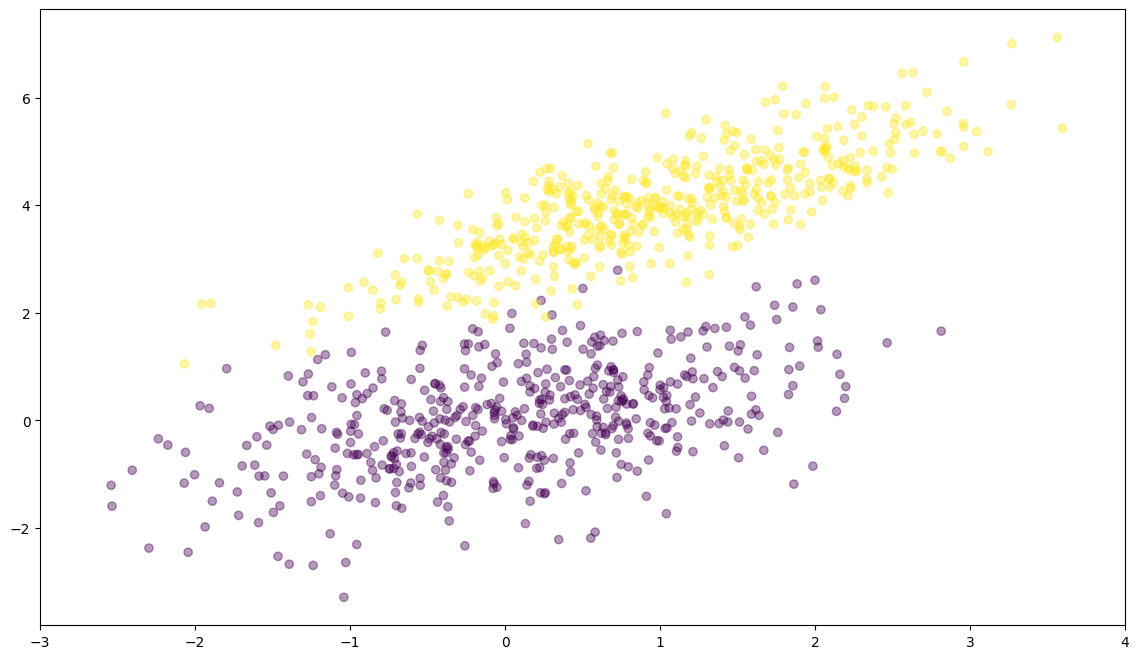

In [32]:
plt.figure(figsize=(14,8))
plt.xlim(-3,4)
plt.scatter(dataset[:, 0], dataset[:, 1],c = labels, alpha = .4)

Our goal is to use a logistic function to fit our dataset. In this case:
$$P_{\rm model}(y_i|{\vec w} \cdot {\vec x_i}) = \frac {e^{({\vec w} \cdot {\vec x_i})y_i}}{1+\exp({\vec w} \cdot {\vec x_i})}$$
such that
$$P_{\rm model}(y_i=1)  = \frac {\exp{({\vec w} \cdot {\vec x_i})}}{1+\exp({\vec w} \cdot {\vec x_i})}  = \frac {1}{1+\exp(-{\vec w} \cdot {\vec x_i})}~~~ \text{and}~~~ P_{\rm model}(y_i=0)  = \frac {1}{1+\exp({\vec w} \cdot {\vec x_i})}  = \frac {\exp{(-{\vec w} \cdot {\vec x_i})}}{1+\exp(-{\vec w} \cdot {\vec x_i})}$$


Now, we can either use the cross-entropy loss and write:
$$\mathcal{L}(\vec{w}) = - \sum_{i=1}^n \sum_{y_i=0,1} y_i \log P_{\rm model}(y_i) +  (1-y_i) \log (1 - P_{\rm model}(y_i)) $$
or equivalently write a maximum-likelihood problem with
$$
\mathcal{L}(\vec{w}|\vec{\bm{x}},\bm{y}) \propto \sum_i \log P_{\rm model}(y_i|{\vec w} \cdot {\vec x_i})
$$
In both cases, the problem boils down to minimizing the following loss:
$$\mathcal{L}(\vec {w}) =  \sum_{i=1}^n - y_i {\vec {w}} \cdot {\vec x}_i  + \log{(1+\exp({\vec w} \cdot {\vec x}_i ))} $$

Let us implement these function:

In [33]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))
def log_loss(features, target, weights): 
    scores = np.dot(features, weights)
    ll = np.sum( -target*scores + np.log(1 + np.exp(scores)) )
    return ll

In order to perform optimization, we need to compute the gradient and perform gradient descent. Here we have:

$$\nabla_{\vec w} \mathcal{L}(\vec w) =  \sum_{i = 1}^n - y_i  {\vec x}_i  + {\vec x}_i  \frac{\exp({\vec w} \cdot {\vec x}_i )}{(1+\exp({\vec w} \cdot {\vec x}_i ))} = - \sum_{i = 1}^n {\vec x}_i^T (y_i - P(y_i=1)) $$

We can now write the  logistic regression

##### **Exercise 1**

##### Try writing Gradient Descent using this Loss, as we did in the previous exercise session

In [34]:
def logistic_regression(features, target, num_steps, learning_rate):

    weights = np.zeros(features.shape[1])##Initialization from 0
    
    for step in range(num_steps):
        scores = np.dot(features, weights)
        predictions = sigmoid(scores)

        # Update weights with gradient
        output_error_signal = target - predictions
        gradient = -np.dot(features.T, output_error_signal)
        weights -= learning_rate * gradient
        
        # Print log-likelihood from time to time
        if step % 10000 == 0:
            print (step," ",log_loss(features, target, weights))
        
    return weights

Remember theoretical lectures? 

We use the usual trick of adding a "1" to the data so that we can actually linear fitting, and call the regression function

In [35]:
intercept = np.ones((dataset.shape[0], 1))
data_with_intercept = np.hstack((intercept, dataset))

We then run the actual GD algorithm

In [36]:
weights = logistic_regression(data_with_intercept, labels, num_steps = 300000, learning_rate = 5e-5)

0   645.1976320327615
10000   32.751191832359176
20000   27.095065275891347
30000   24.836811224952655
40000   23.593936566289752
50000   22.803112650970398
60000   22.255870323028482
70000   21.855786948699006
80000   21.55169925537929
90000   21.313784058969752
100000   21.123421954281334
110000   20.968362287170734
120000   20.840203784078454
130000   20.732988348642635
140000   20.6423716693823
150000   20.565111368581015
160000   20.498738918089238
170000   20.441342465252287
180000   20.391419037920045
190000   20.347771512096905
200000   20.30943524982975
210000   20.275624876363842
220000   20.245695018470037
230000   20.219110905131664
240000   20.195426054123942
250000   20.174265128187454
260000   20.155310615551997
270000   20.138292375753814
280000   20.12297935729693
290000   20.109172979225384


Now we can plot the prediction from our model, and check how good they are on the training dataset

In [37]:
def line(x,a,b,c):
    return -x*b/c-a/c
def myline(x):
    a = weights[0]
    b = weights[1]
    c = weights[2]
    return -x*b/c-a/c

final_scores = np.dot(data_with_intercept, weights)
preds = np.round(sigmoid(final_scores))

print('Accuracy: {0}'.format((preds == labels).sum().astype(float) / len(preds)))

Accuracy: 0.991


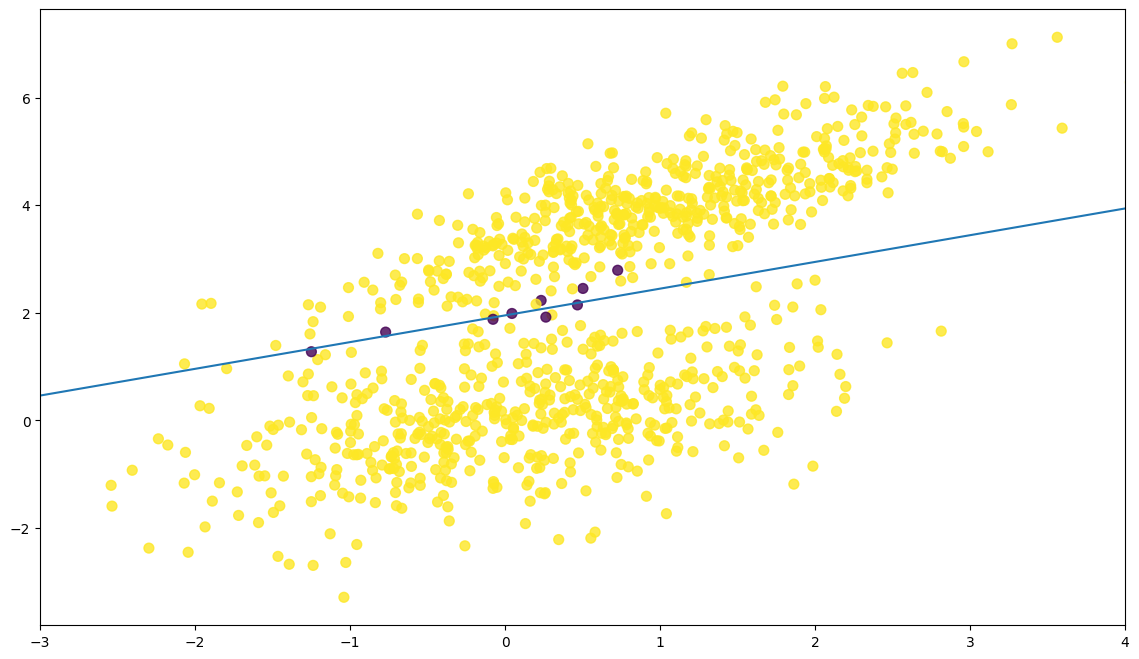

In [38]:
plt.figure(figsize = (14, 8))
plt.scatter(dataset[:, 0], dataset[:, 1],
            c = (preds == labels) , alpha = .8, s = 50)
plt.xlim([-3,4])
plt.plot([-3,4],[myline(-3),myline(4)])

In high dimensional statistics problems, it is often the case that the number of points are of the same order as the dimension. Let us mimick this by using fewer points in dimension 2!

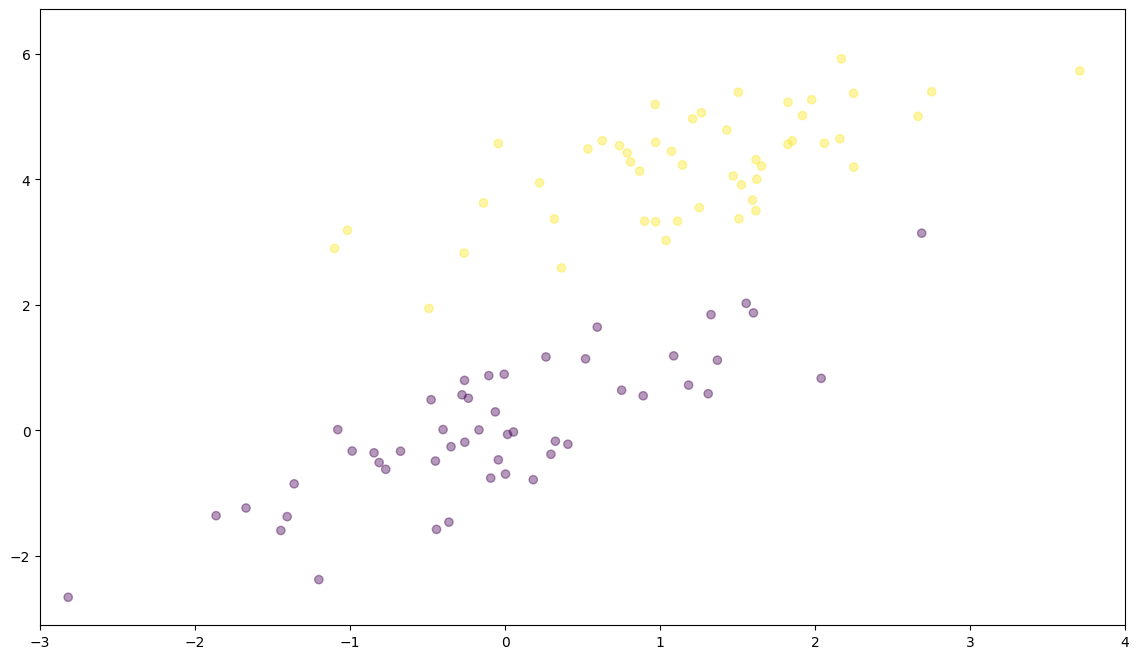

In [39]:
num_observations = 50

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

dataset = np.vstack((x1, x2)).astype(np.float32)
labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))
plt.figure(figsize=(14,8))
plt.xlim([-3,4])
plt.scatter(dataset[:, 0], dataset[:, 1], c = labels, alpha = .4)

Of course, we could just redo our fit

In [40]:
intercept = np.ones((dataset.shape[0], 1))
data_with_intercept = np.hstack((intercept, dataset))

weights = logistic_regression(data_with_intercept, labels,num_steps = 100000, learning_rate = 1e-1)

0   296.89887887568767
10000   0.01253836504248739
20000   0.006544884676131536
30000   0.004461906055359928
40000   0.0033958933953699456
50000   0.0027460014174589768
60000   0.002307507437644334
70000   0.0019912936690457475
80000   0.0017522594577792502
90000   0.0015651013439884974


Accuracy: 1.0


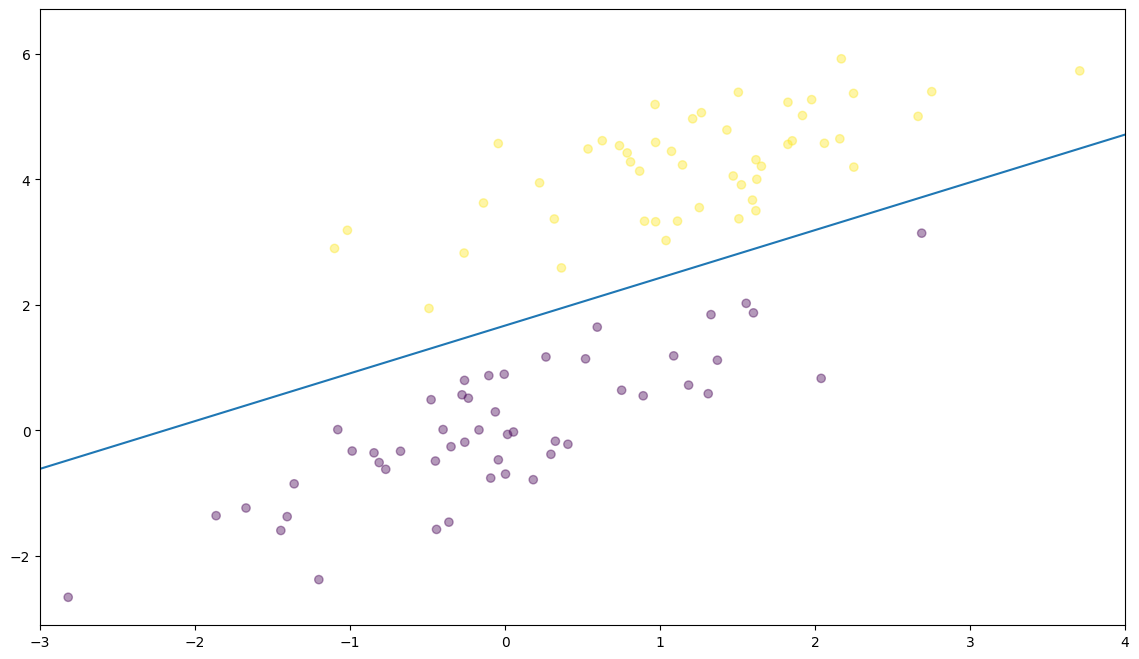

In [41]:
def myline(x):
    return line(x,weights[0],weights[1],weights[2])

plt.figure(figsize=(14,8))
plt.xlim([-3,4])
plt.scatter(dataset[:, 0], dataset[:, 1], c = labels, alpha = .4)
plt.plot([-3,4],[myline(-3),myline(4)])

final_scores = np.dot(data_with_intercept, weights)
preds = np.round(sigmoid(final_scores))
print('Accuracy: {0}'.format((preds == labels).sum().astype(float) / len(preds)))

# 2) Logistic regression on real dataset 



Let us use the fantastic notebooks from https://physics.bu.edu/~pankajm/MLnotebooks.html, a terrific book for ML newcomers especially if they come from physics. We will consider again our friend MNIST, remember the lecture on KNN? First a bit of history on this famous dataset:


The MNIST classification problem is one of the classical ML problems for learning classification on high-dimensional data with a fairly sizable number of examples (60000). Yann LeCun and collaborators collected and processed $70000$ handwritten digits (60000 are used for training and 10000 for testing) to produce what became known as one of the most widely used datasets in ML: the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Each handwritten digit comes in a grayscale square image in the shape of a $28\times 28$ pixel grid. Every pixel takes a value in the range $[0,255]$, representing $256$ nuances of the gray color. The problem of image classification finds applications in a wide range of fields and is important for numerous industry applications of Machine Learning.

 ### SoftMax regression:
 Before we consider two possible labels for our data, you can easily guess that it is amenable to have more than one in this case. 

 Do not worry! We can easily generalize what we said before. 


We will use SoftMax regression, which can be thought of as a statistical model which assigns a probability that a given input image corresponds to any of the 10 handwritten digits. The model is a generalization of the logistic regression and reads:
$$
p(y_i=j|\vec{x}_i;\vec{w}) = \frac{e^{-\vec{w}_j^T \vec{x}}}{\sum_{k=0}^9 e^{-\vec{w}_k^T\vec{x} }},
$$
Where $p(y_i=j|\vec{x}_i;\vec{w})$ is the probability that input $\vec{x}_i$ is the $j$-th digit, $j\in[0,9]$.
The model also has 10 weight vectors $\vec{w}_j$ which we will train below. Finally, one can use this information for prediction by taking the value of $y_i$ for which this probability is maximized:
\begin{align}
y_{pred}=\arg\max_i p(y=i|\vec{x})
\end{align}

First thing to do is to import the dataset and preprocess the data:


In [42]:
import time


from sklearn.datasets import fetch_openml # MNIST data
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

print(__doc__)

# Turn down for faster convergence
train_size = 60000
test_size = 10000

### load MNIST data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


Automatically created module for IPython interactive environment


In [43]:
X = np.asarray(X)
y = np.asarray(y)

Let's plot an image to see how it looks like with plt.imshow.

'4'

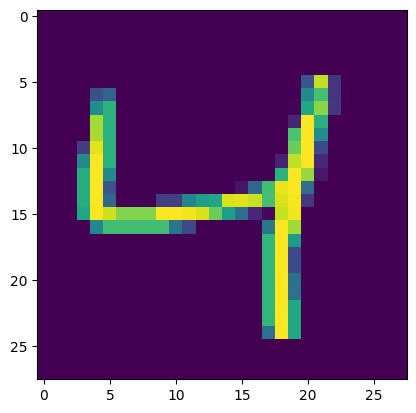

In [44]:
plt.imshow(X[2,:].reshape(28,28))
y[2]

We shuffle the data and we do the test-train splitting.

In [45]:
# shuffle data
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
# pick training and test data sets 
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size,test_size=test_size)

We preproccess the data and use StandardScaler to have zero mean and unit variance. Pay attention that we do that only on the training set!

In [46]:
# scale data to have zero mean and unit variance [required by regressor]
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
#X_test = scaler.transform(X_test)

**Exercise** 
 1. You need to learn how to read a Python documentation. Search on the internet how to implement softmax regression.
 2. Fix the value of the regularization to be $10^{-5}$. Fit the data and compute two quantities: 
   - Sparsity of the weights (percentage of non-zero weights)
   - Score (i.e. accuracy)

In [47]:
# apply logistic regressor with 'sag' solver, C is the inverse regularization strength
t0=time.time()
clf = LogisticRegression(C=1e5,
                         multi_class='multinomial',
                         penalty='l2', solver='sag', tol=0.1)
# fit data
clf.fit(X_train, y_train)
# percentage of nonzero weights
sparsity = np.mean(clf.coef_ == 0) * 100
# compute accuracy
score = clf.score(X_test, y_test)

#display run time
run_time = time.time() - t0
print('Example run in %.3f s' % run_time)

print("Sparsity with L2 penalty: %.2f%%" % sparsity)
print("Test score with L2 penalty: %.4f" % score)

# define the vector of parameters as 
coef = clf.coef_.copy()

/home/filippoquadri/miniconda3/envs/foil/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Example run in 3.538 s
Sparsity with L2 penalty: 8.29%
Test score with L2 penalty: 0.6847


##### Let us see how we can actually plot the weights against the pixels!!

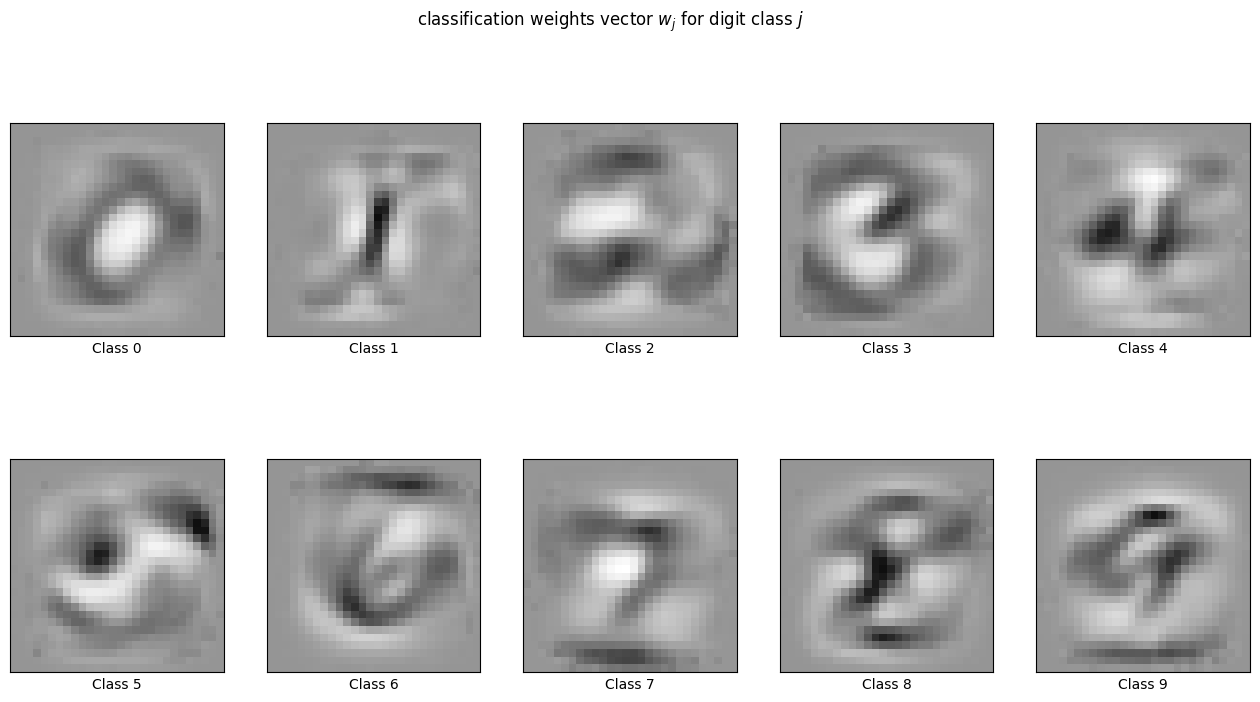

In [48]:
# plot weights vs the pixel position
plt.figure(figsize=(16, 8))
scale = np.abs(coef).max()
for i in range(10):
    l2_plot = plt.subplot(2, 5, i + 1)
    l2_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.Greys, vmin=-scale, vmax=scale)
    l2_plot.set_xticks(())
    l2_plot.set_yticks(())
    l2_plot.set_xlabel('Class %i' % i)
plt.suptitle('classification weights vector $w_j$ for digit class $j$')
plt.show()

# 3) SVM Classification on real dataset 


**Exercise**
 1. Repeat what you did for softmax regression for an Support Vector Machine (SVM) linear classifier.
 2. Go and search the Python doc for SVM classifier. Choose the linear one (we will see other in following lectures)
 3. Fit the data using the default value of regularization and compare with an optimized value using CV.

Clear and friendly reference can be found here: https://www.kaggle.com/nishan192/mnist-digit-recognition-using-svm. 

PS: If you do not know Kaggle, you should check it out!

In [49]:
from sklearn.svm import LinearSVC

In [50]:
# scale data to have zero mean and unit variance [required by regressor]
scaler = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [51]:
# using linear kernel, C=1, default value of gamma

# model
model = LinearSVC(loss='hinge',max_iter=10000,C=0.01)

# fit
model.fit(X_train, y_train)

# predict
y_pred = model.predict(X_test)

/home/filippoquadri/miniconda3/envs/foil/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [52]:
model.score(X_test,y_test)

0.9073571428571429

We can also fine-tune the parameter with cross-validation. 

In [53]:
from sklearn.model_selection import validation_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import pandas as pd


In [54]:

# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 10)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'C': [10e-4,10e-3,0.01,0.1,1]}]


# specify model
model = LinearSVC(loss='hinge',max_iter=1000,dual='auto')

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True,
                        n_jobs = -1 # number of cores to be used!!
)      

# fit the model
model_cv.fit(X_train, y_train)
print("Train score: ", model_cv.score(X_train,y_train))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/home/filippoquadri/miniconda3/envs/foil/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/filippoquadri/miniconda3/envs/foil/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/filippoquadri/miniconda3/envs/foil/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/filippoquadri/miniconda3/envs/foil/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home/filippoquadri/miniconda3/envs/foil/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/home

Train score:  0.9313928571428571


/home/filippoquadri/miniconda3/envs/foil/lib/python3.12/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [55]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,60.407315,3.534528,0.067006,0.016445,0.001,{'C': 0.001},0.890000,0.892500,0.888125,0.892946,...,0.891268,0.001901,5,0.899085,0.899330,0.900379,0.898438,0.898661,0.899179,0.000677
1,83.982989,2.337285,0.048156,0.012800,0.010,{'C': 0.01},0.909107,0.908571,0.905000,0.910089,...,0.908839,0.002152,3,0.923103,0.924955,0.924621,0.923103,0.923036,0.923763,0.000844
2,81.398348,0.858801,0.062759,0.012812,0.010,{'C': 0.01},0.909286,0.908036,0.905000,0.910089,...,0.908786,0.002205,4,0.923058,0.925000,0.924687,0.923192,0.923080,0.923804,0.000856
3,163.834212,6.525502,0.034669,0.004894,0.100,{'C': 0.1},0.916161,0.911250,0.909821,0.915714,...,0.913625,0.002581,1,0.933259,0.933527,0.933482,0.931205,0.933237,0.932942,0.000876
4,347.071379,20.250418,0.024628,0.002525,1.000,{'C': 1},0.912857,0.908839,0.907411,0.911696,...,0.910518,0.002046,2,0.933371,0.935112,0.934844,0.933147,0.935491,0.934393,0.000951


In [56]:
# printing the optimal accuracy score and hyperparameters
best_score = model_cv.best_score_
best_hyperparams = model_cv.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.9136249999999999 corresponding to hyperparameters {'C': 0.1}


In [57]:
cvOptParams = model_cv.best_estimator_.coef_

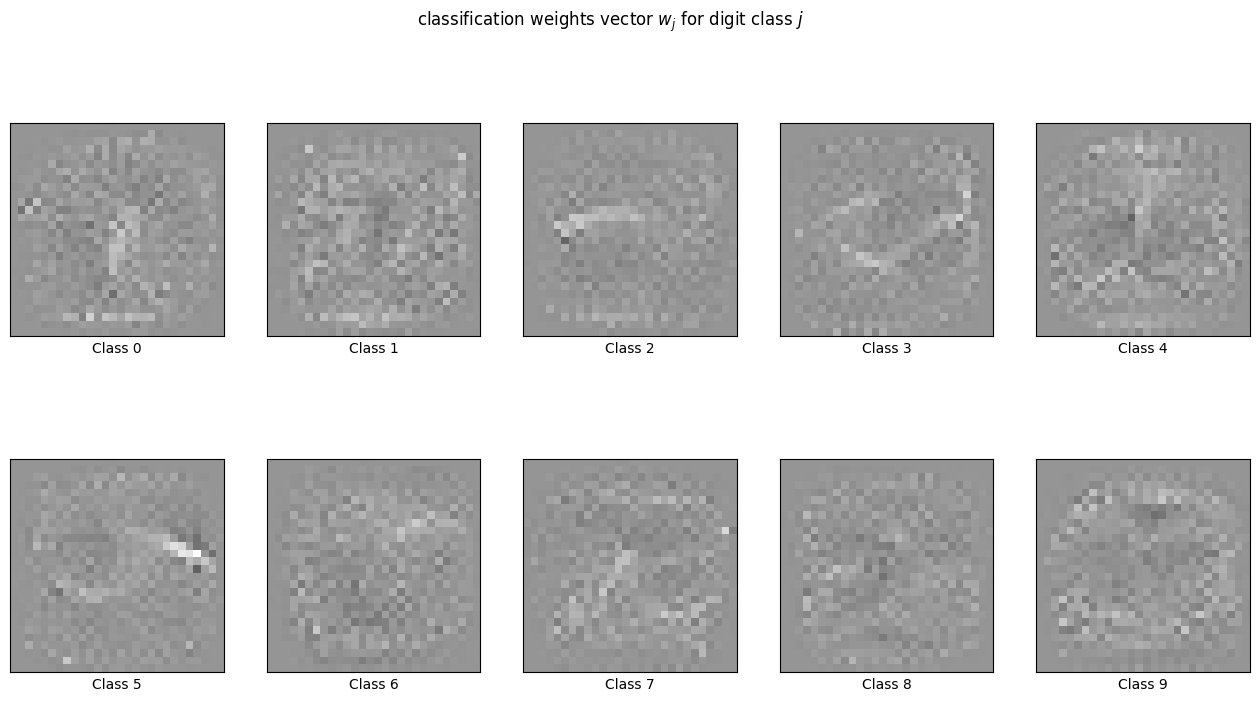

In [58]:
# plot weights vs the pixel position
coef = cvOptParams.copy()
plt.figure(figsize=(16, 8))
scale = np.abs(coef).max()
for i in range(10):
    l2_plot = plt.subplot(2, 5, i + 1)
    l2_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.Greys, vmin=-scale, vmax=scale)
    l2_plot.set_xticks(())
    l2_plot.set_yticks(())
    l2_plot.set_xlabel('Class %i' % i)
plt.suptitle('classification weights vector $w_j$ for digit class $j$')
plt.show()